In [ ]:
!pip install transformers datasets evaluate peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 15.5 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=2ea14628152fffa6def46df4675e4a79f828267942087a9527d1aea25efc7db8
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score


In [ ]:
!pip install bert_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 5.5 MB/s eta 0:00:00


In [ ]:
# FLAN-T5-XL + LoRA (PEFT)

# Environment and cleanup
import os, gc, random
import numpy as np
import torch

# Helps reduce CUDA fragmentation spikes
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Reproducibility
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# If rerunning the cell, free stale objects first
for n in ["trainer", "model", "tokenizer"]:
    if n in globals():
        try:
            del globals()[n]
        except:
            pass
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()

assert torch.cuda.is_available(), "This script expects a GPU (T4)."
device = torch.device("cuda")

In [ ]:
# STEP 1: Load and clean MedDialog dataset
import json
import pandas as pd
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split

def load_and_filter_dataset(path):
    with open(path, "r") as f:
        data = json.load(f)
    cleaned = []
    for entry in data:
        utt = entry.get("utterances", [])
        if len(utt) < 2:
            continue
        patient = utt[0].replace("patient:", "").strip()
        doctor  = utt[1].replace("doctor:", "").strip()
        # Keep medium-length, clean answers
        if 10 < len(doctor.split()) < 100:
            prompt = (
                "You are a helpful telehealth doctor. Provide a short, clear response.\n"
                f"Patient: {patient}\nDoctor:"
            )
            cleaned.append({"input": prompt, "output": doctor})
    return pd.DataFrame(cleaned)

train_df = load_and_filter_dataset("english-train.json")
val_df   = load_and_filter_dataset("english-dev.json")
test_df  = load_and_filter_dataset("english-test.json")

# 20% of train - benchmark/eval split (train 1600, eval 401)
train_df, benchmark_df = train_test_split(train_df, test_size=0.2, random_state=SEED)

dataset = DatasetDict({
    "train":     Dataset.from_pandas(train_df.reset_index(drop=True)),
    "benchmark": Dataset.from_pandas(benchmark_df.reset_index(drop=True)),
    "test":      Dataset.from_pandas(test_df.reset_index(drop=True)),
})

In [ ]:
# After loading all datasets
print("Dataset Sizes")
print(f"Total samples before split (train.json): {len(load_and_filter_dataset('english-train.json'))}")
print(f"Validation (dev.json): {len(val_df)}")
print(f"Test (test.json): {len(test_df)}")

# Sizes after your 80/20 split
print("\nAfter Split (train - train + benchmark)")
print(f"Train size: {len(train_df)}")
print(f"Benchmark (20% of train): {len(benchmark_df)}")
print(f"Validation (dev): {len(val_df)}")
print(f"Test size: {len(test_df)}")

# Final
print("\nFinal")
print(f"Total samples before split: {len(train_df) + len(benchmark_df)}")
print(f"Train size: {len(train_df)}")
print(f"Eval size: {len(benchmark_df)}")
print(f"Test size: {len(test_df)}")

Dataset Sizes
Total samples before split (train.json): 2001
Validation (dev.json): 142
Test (test.json): 355

After Split (train - train + benchmark)
Train size: 1600
Benchmark (20% of train): 401
Validation (dev): 142
Test size: 355

Final
Total samples before split: 2001
Train size: 1600
Eval size: 401
Test size: 355


In [ ]:
# STEP 2: Tokenize data for flan-t5-xl
from transformers import T5Tokenizer

model_name = "google/flan-t5-xl"
tokenizer  = T5Tokenizer.from_pretrained(model_name)

# Runtime-friendly lengths
INPUT_MAX_LEN  = 256
TARGET_MAX_LEN = 96

# Preprocessing
def preprocess(batch):
    # Encoder inputs
    enc = tokenizer(
        batch["input"],
        truncation=True,
        max_length=INPUT_MAX_LEN,
    )
    # Decoder targets
    with tokenizer.as_target_tokenizer():
        dec = tokenizer(
            batch["output"],
            truncation=True,
            max_length=TARGET_MAX_LEN,
        )
    input_ids      = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    labels         = dec["input_ids"]
    # Mask out padding tokens in labels
    labels = [[tid if tid != tokenizer.pad_token_id else -100 for tid in seq] for seq in labels]
    return {
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Map with multiprocessing for speed
tokenized_dataset = dataset.map(
    preprocess,
    batched=True,
    remove_columns=dataset["train"].column_names,
    num_proc=2
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Map (num_proc=2):   0%|          | 0/356 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/89 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map (num_proc=2):   0%|          | 0/52 [00:00<?, ? examples/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:4007: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


In [ ]:
# Load model (4-bit) and add LoRA
from transformers import T5ForConditionalGeneration, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

# Pin to GPU 0 to avoid offload validator issues
model = T5ForConditionalGeneration.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map={"": 0},
)

# STEP 3: Setup PEFT LoRA config
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q", "k", "v", "o", "wi", "wo"],  # T5 proj/ffn modules
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM,
)

model = get_peft_model(model, lora_config)

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
# STEP 4: Setup Trainer
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

EPOCHS   = 3
LR       = 2e-4
BATCH    = 1
GRAD_ACC = 2  # effective batch = 2

training_args = Seq2SeqTrainingArguments(
    output_dir="./flan-t5-xl-telehealth-lora",
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=GRAD_ACC,
    lr_scheduler_type="cosine",
    warmup_ratio=0.03,
    weight_decay=0.01,
    logging_steps=50,
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,                 # T4 supports FP16
    report_to="none",
    seed=SEED,

    # Seq2Seq-friendly defaults
    predict_with_generate=False,
    generation_max_length=80,
)

trainer_kwargs = dict(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    data_collator=data_collator,
)
try:
    trainer = Seq2SeqTrainer(**trainer_kwargs, processing_class=tokenizer)
except TypeError:
    trainer = Seq2SeqTrainer(**trainer_kwargs, tokenizer=tokenizer)

trainer.train()

# Save LoRA adapters + tokenizer
save_dir = "./flan-t5-xl-telehealth-lora"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)


Step,Training Loss
50,0.000000
100,0.000000
150,0.000000
200,0.000000
250,0.000000
300,0.000000
350,0.000000
400,0.000000
450,0.000000
500,10.355400


('./flan-t5-xl-telehealth-lora/tokenizer_config.json',
 './flan-t5-xl-telehealth-lora/special_tokens_map.json',
 './flan-t5-xl-telehealth-lora/spiece.model',
 './flan-t5-xl-telehealth-lora/added_tokens.json')

In [ ]:
# STEP 5: Evaluate (ROUGE + BERTScore)

from transformers import AutoModelForSeq2SeqLM
from peft import PeftModel
from evaluate import load as load_metric

# Free training graphs to lower peak VRAM during eval
del trainer
gc.collect()
torch.cuda.empty_cache()

rouge = load_metric("rouge")
bertscore = load_metric("bertscore")

def load_base_4bit_gpu(name: str):
    return AutoModelForSeq2SeqLM.from_pretrained(
        name,
        quantization_config=bnb_config,
        device_map={"": 0},
        low_cpu_mem_usage=True,
    )

def load_lora_4bit_gpu(name: str, lora_path: str):
    base = AutoModelForSeq2SeqLM.from_pretrained(
        name,
        quantization_config=bnb_config,
        device_map={"": 0},
        low_cpu_mem_usage=True,
    )
    return PeftModel.from_pretrained(base, lora_path, device_map={"": 0})

# Evaluate on full benchmark by default (set to an int to cap for speed)
EVAL_LIMIT = None   # use 401 (your eval size) or keep None for full

def evaluate_model(model, hf_ds, limit=EVAL_LIMIT):
    model.eval()
    # Reduce VRAM during generation
    if hasattr(model, "generation_config"):
        model.generation_config.use_cache = False

    preds, refs = [], []
    df = hf_ds.to_pandas()
    if limit is not None:
        df = df.head(limit)

    with torch.inference_mode():
        for _, row in df.iterrows():
            prompt = row["input"]
            enc = tokenizer(
                prompt,
                return_tensors="pt",
                truncation=True,
                padding="max_length",
                max_length=256,   # short encoder length for speed
            )
            enc = {k: v.to(model.device) for k, v in enc.items()}

            out_ids = model.generate(
                **enc,
                max_new_tokens=80,   # modest cap to keep runtime stable
                num_beams=1,         # greedy = fastest/leanest
                do_sample=False,
                early_stopping=True,
                no_repeat_ngram_size=3,
                repetition_penalty=1.2,
                use_cache=False,
            )
            preds.append(tokenizer.decode(out_ids[0], skip_special_tokens=True))
            refs.append(row["output"])

    rouge_res = rouge.compute(predictions=preds, references=refs)

    # BERTScore on CPU, light backbone to avoid extra VRAM
    bert_res = bertscore.compute(
        predictions=preds,
        references=refs,
        lang="en",
        model_type="bert-base-uncased",
        device="cpu",
        batch_size=32,
        rescale_with_baseline=False,
    )
    bert_f1 = float(sum(bert_res["f1"]) / len(bert_res["f1"])) if len(bert_res["f1"]) else 0.0
    return rouge_res, bert_f1

print("Evaluating Pretrained Base Model on Benchmark Dataset...")
base_model = load_base_4bit_gpu(model_name)
pre_rouge, pre_bert = evaluate_model(base_model, dataset["benchmark"], limit=EVAL_LIMIT)
del base_model; gc.collect(); torch.cuda.empty_cache()

print("Evaluating LoRA Fine-Tuned Model on Benchmark Dataset...")
lora_model = load_lora_4bit_gpu(model_name, save_dir)
lora_rouge, lora_bert = evaluate_model(lora_model, dataset["benchmark"], limit=EVAL_LIMIT)
del lora_model; gc.collect(); torch.cuda.empty_cache()

# Report
comparison_df = pd.DataFrame({
    "Metric": ["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"],
    "Pretrained": [
        pre_rouge.get("rouge1", 0.0),
        pre_rouge.get("rouge2", 0.0),
        pre_rouge.get("rougeL", 0.0),
        pre_bert,
    ],
    "LoRA Fine-Tuned": [
        lora_rouge.get("rouge1", 0.0),
        lora_rouge.get("rouge2", 0.0),
        lora_rouge.get("rougeL", 0.0),
        lora_bert,
    ],
})
print(comparison_df)
comparison_df.to_csv("benchmark_model_comparison.csv", index=False)

Evaluating Pretrained Base Model on Benchmark Dataset...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

The following generation flags are not valid and may be ignored: ['early_stopping']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Evaluating LoRA Fine-Tuned Model on Benchmark Dataset...


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

         Metric  Pretrained  LoRA Fine-Tuned
0       ROUGE-1    0.108616         0.108616
1       ROUGE-2    0.013090         0.013090
2       ROUGE-L    0.085083         0.085083
3  BERTScore-F1    0.415264         0.415264


/tmp/ipython-input-1244945524.py:46: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  x = df["step"].fillna(method="ffill").fillna(0); xlabel = "Step"


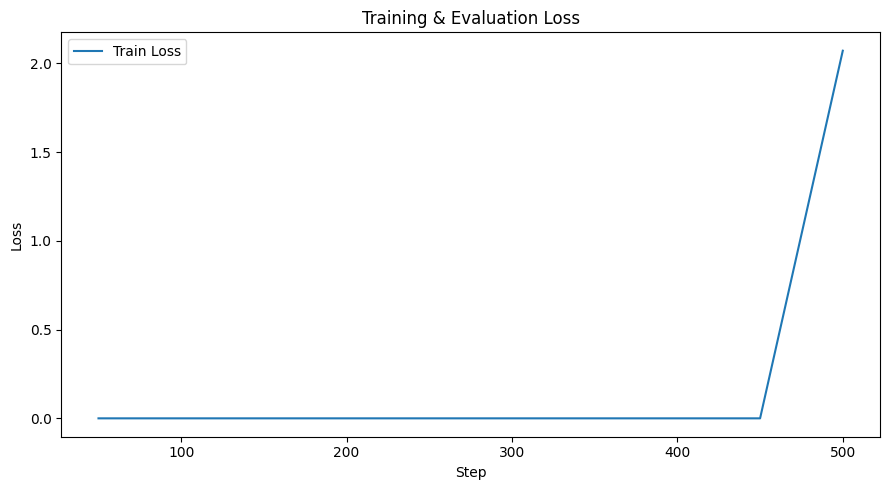

Saved: ./flan-t5-xl-telehealth-lora/training_eval_loss.png


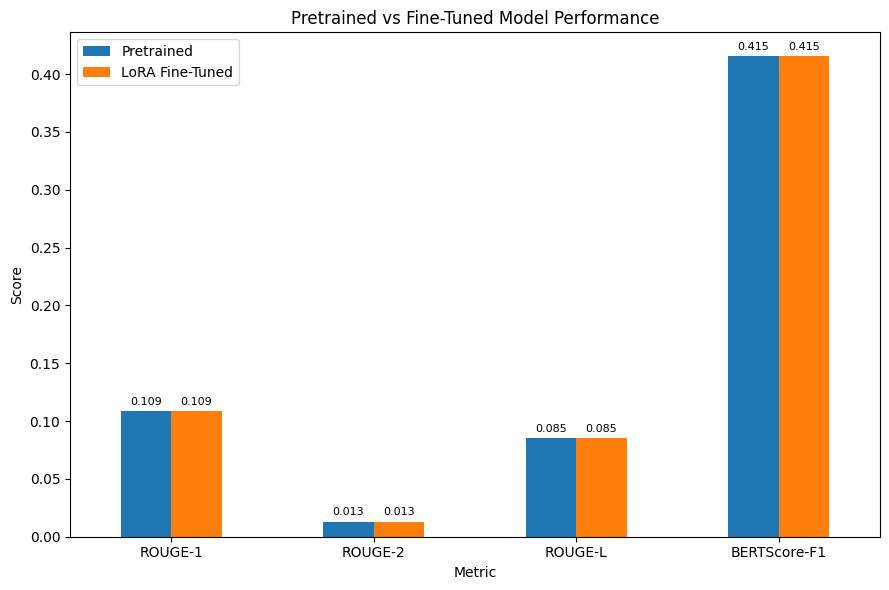

Saved: model_comparison_metrics.png


In [ ]:
# Two Visualizations
# 1) Training & Evaluation Loss
# 2) Pretrained vs Fine-Tuned Model Performance
import os, json
import pandas as pd
import matplotlib.pyplot as plt

OUTPUT_DIR = "./flan-t5-xl-telehealth-lora"   # your training output_dir
CMP_CSV    = "benchmark_model_comparison.csv" # written in Step 5

# ---- helpers ----
def _load_logs(output_dir: str) -> pd.DataFrame:
    """Load logs from OUTPUT_DIR/log_history.csv if present,
    else search checkpoints for trainer_state.json and use the latest."""
    csv_path = os.path.join(output_dir, "log_history.csv")
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    # search subfolders for trainer_state.json
    best = None
    for root, _, files in os.walk(output_dir):
        if "trainer_state.json" in files:
            path = os.path.join(root, "trainer_state.json")
            try:
                with open(path, "r") as f:
                    state = json.load(f)
                step = state.get("global_step", 0) or 0
                if best is None or step > best[0]:
                    best = (step, state)
            except Exception:
                pass
    if best is None:
        raise FileNotFoundError(
            f"No logs found under {output_dir}. "
            "Save logs after training or keep at least one checkpoint."
        )
    df = pd.DataFrame(best[1].get("log_history", []))
    # normalize expected columns
    for c in ["step","epoch","loss","eval_loss"]:
        if c not in df.columns: df[c] = pd.Series(dtype="float64")
    return df

def plot_training_eval_loss(output_dir: str, out_png: str = None, smooth: int = 5):
    df = _load_logs(output_dir).copy()
    # x-axis preference: step -> epoch -> index
    if "step" in df and df["step"].notna().any():
        x = df["step"].fillna(method="ffill").fillna(0); xlabel = "Step"
    elif "epoch" in df and df["epoch"].notna().any():
        x = df["epoch"].fillna(method="ffill").fillna(0); xlabel = "Epoch"
    else:
        x = range(len(df)); xlabel = "Record #"
    plt.figure(figsize=(9,5))
    if "loss" in df and df["loss"].notna().any():
        y = df["loss"]
        if smooth and smooth > 1:
            y = y.rolling(window=smooth, min_periods=1).mean()
        plt.plot(x, y, label="Train Loss")
    if "eval_loss" in df and df["eval_loss"].notna().any():
        plt.plot(x, df["eval_loss"], label="Eval Loss")
    plt.xlabel(xlabel); plt.ylabel("Loss"); plt.title("Training & Evaluation Loss")
    plt.legend(); plt.tight_layout()
    if out_png is None:
        out_png = os.path.join(output_dir, "training_eval_loss.png")
    plt.savefig(out_png, dpi=150); plt.show()
    print(f"Saved: {out_png}")

def plot_pretrained_vs_lora(csv_path: str = CMP_CSV, out_png: str = "model_comparison_metrics.png"):
    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"{csv_path} not found. Run Step 5 to create it.")
    cdf = pd.read_csv(csv_path)
    ax = cdf.set_index("Metric").plot(kind="bar", figsize=(9,6))
    plt.title("Pretrained vs Fine-Tuned Model Performance")
    plt.ylabel("Score"); plt.xticks(rotation=0)
    plt.tight_layout()
    # annotate bars with values
    for p in ax.patches:
        h = p.get_height()
        ax.annotate(f"{h:.3f}", (p.get_x()+p.get_width()/2., h),
                    ha="center", va="bottom", fontsize=8, xytext=(0,3),
                    textcoords="offset points")
    plt.savefig(out_png, dpi=150); plt.show()
    print(f"Saved: {out_png}")

# run the two plots
plot_training_eval_loss(OUTPUT_DIR)                  # training & eval loss
plot_pretrained_vs_lora(CMP_CSV)                     # pretrained vs fine-tuned


In [ ]:
# Prompt engineering
# Step 1: Define the prompt engineering template with enhanced responses
def build_prompt(input_text, prompt_type="general"):
    input_text = input_text.strip()

    if prompt_type == "general":
        return (
            f"You are a helpful telehealth doctor. Provide a clear, actionable response with medical context and next steps.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "diagnosis":
        return (
            f"You are a licensed telehealth physician. Assess the symptoms and explain 1-2 possible causes with suggested next steps.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "psychological":
        return (
            f"You are a compassionate telehealth doctor. Reassure the patient, then provide steps to manage their mental well-being.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    elif prompt_type == "medication":
        return (
            f"You are a helpful telehealth doctor. If medication is needed, suggest general types (not specific brands). Include dosage instructions and when to consult with a healthcare provider.\n"
            f"Patient: {input_text}\nDoctor:"
        )

    else:
        raise ValueError("Unsupported prompt type.")

In [ ]:
# Step 2: Generate answers based on the prompt type
def generate_answer(input_text, model, tokenizer, prompt_type="general"):
    prompt = build_prompt(input_text, prompt_type)
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(model.device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=128,   # 64
        num_beams=4,
        early_stopping=True,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3
    )

    response = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    if response.lower().startswith("doctor:"):
        response = response[7:].strip()
    return response

In [ ]:
# Step 3: Evaluate the model with different prompt types
def evaluate_model(model, tokenizer, test_df, prompt_type="general"):
    from evaluate import load
    rouge = load("rouge")
    bertscore = load("bertscore")

    preds, refs = [], []
    for _, row in test_df.iterrows():
        patient_text = row["input"].split("Patient:")[1].split("\n")[0].strip()
        prompt = build_prompt(patient_text, prompt_type)
        inputs = tokenizer(prompt, return_tensors="pt", truncation=True, padding="max_length", max_length=512).to(model.device)
        outputs = model.generate(
            **inputs,
            max_new_tokens=64,
            num_beams=4,
            early_stopping=True,
            repetition_penalty=1.2,
            no_repeat_ngram_size=3
        )
        preds.append(tokenizer.decode(outputs[0], skip_special_tokens=True))
        refs.append(row["output"])

    rouge_result = rouge.compute(predictions=preds, references=refs)
    bert_result = bertscore.compute(predictions=preds, references=refs, lang="en")
    return rouge_result, sum(bert_result["f1"]) / len(bert_result["f1"])

In [ ]:
# Step 4: Perform evaluation with different prompt types

results = []

for prompt_type in ["general", "diagnosis", "psychological", "medication"]:
    rouge_result, bert_f1 = evaluate_model(model, tokenizer, test_df, prompt_type=prompt_type)
    results.append({
        "Prompt Type": prompt_type,
        "ROUGE-1": rouge_result["rouge1"],
        "ROUGE-2": rouge_result["rouge2"],
        "ROUGE-L": rouge_result["rougeL"],
        "BERTScore-F1": bert_f1
    })
    print(f"\nPrompt Type: {prompt_type}")
    print(f"ROUGE-1: {rouge_result['rouge1']:.4f}")
    print(f"ROUGE-2: {rouge_result['rouge2']:.4f}")
    print(f"ROUGE-L: {rouge_result['rougeL']:.4f}")
    print(f"BERTScore-F1: {bert_f1:.4f}")

# Convert results to DataFrame
df_results = pd.DataFrame(results)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: general
ROUGE-1: 0.1195
ROUGE-2: 0.0170
ROUGE-L: 0.0894
BERTScore-F1: 0.8398


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: diagnosis
ROUGE-1: 0.1319
ROUGE-2: 0.0164
ROUGE-L: 0.0874
BERTScore-F1: 0.8317


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: psychological
ROUGE-1: 0.1420
ROUGE-2: 0.0148
ROUGE-L: 0.1006
BERTScore-F1: 0.8426


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Prompt Type: medication
ROUGE-1: 0.1306
ROUGE-2: 0.0146
ROUGE-L: 0.0969
BERTScore-F1: 0.8396


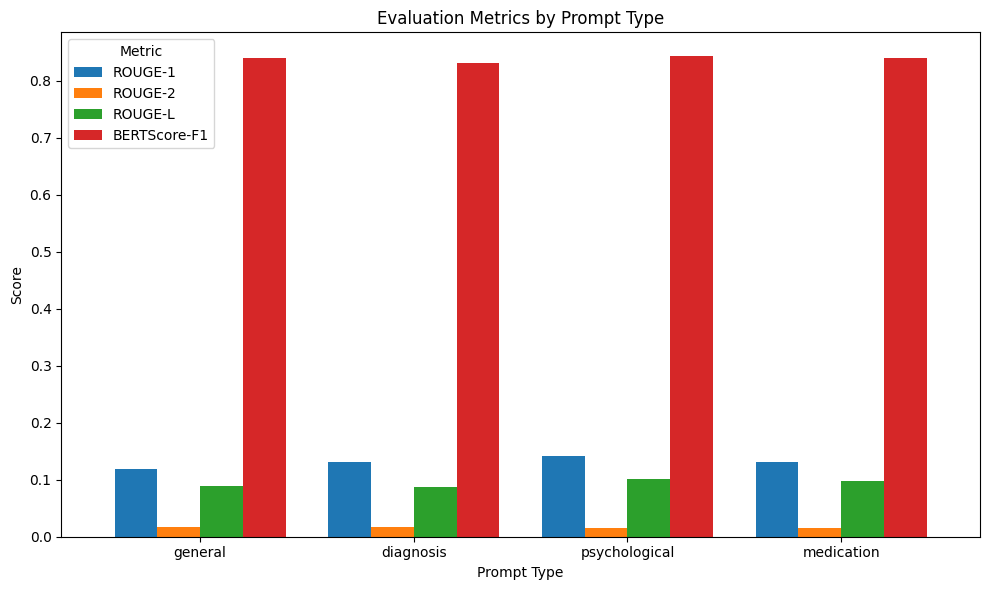

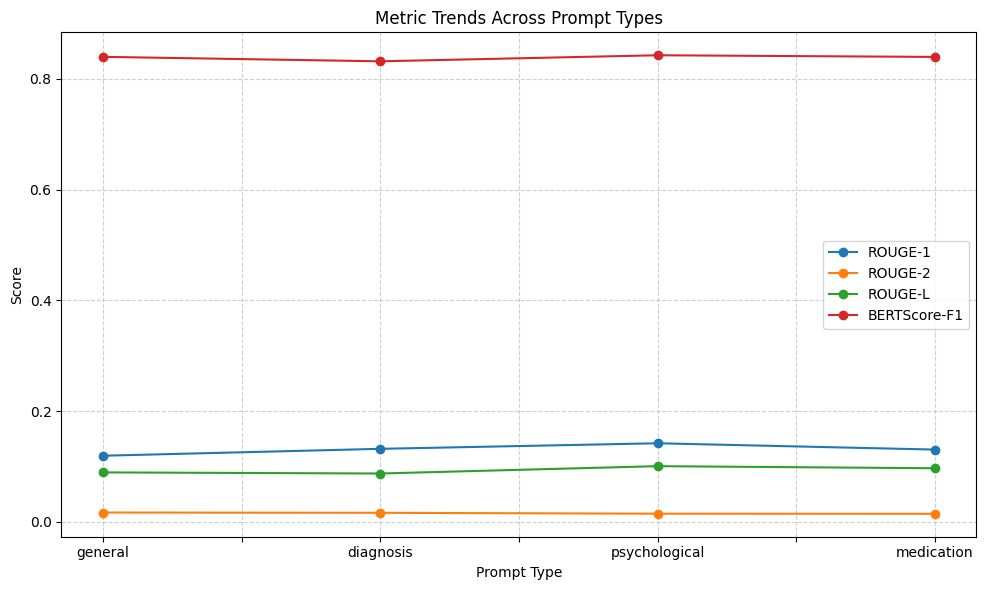

In [ ]:
# Visualization 1: Grouped Bar Plot (comparison across metrics)
df_results.set_index("Prompt Type")[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"]].plot(
    kind="bar", figsize=(10,6), width=0.8
)
plt.title("Evaluation Metrics by Prompt Type")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.tight_layout()
plt.savefig("prompt_type_evaluation.png")
plt.show()

# Visualization 2: Line Plot (trend across prompt types)
df_results.set_index("Prompt Type")[["ROUGE-1", "ROUGE-2", "ROUGE-L", "BERTScore-F1"]].plot(
    kind="line", marker="o", figsize=(10,6)
)
plt.title("Metric Trends Across Prompt Types")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.savefig("prompt_type_trends.png")
plt.show()

In [ ]:
# Step 5: Interactive Chat with the model
def chat_with_model(model, tokenizer):
    print("\nTelehealth Assistant is ready.")
    print("Please choose a prompt mode:")
    print("1 - General")
    print("2 - Diagnosis")
    print("3 - Psychological")
    print("4 - Medication")

    mode_map = {
        "1": "general",
        "2": "diagnosis",
        "3": "psychological",
        "4": "medication"
    }

    mode = input("Enter mode number (1-4): ").strip()
    prompt_type = mode_map.get(mode, "general")  # default to general

    print(f"\nPrompt mode set to [{prompt_type.upper()}]. Type 'exit' to quit.\n")

    while True:
        user_input = input("Patient: ").strip()
        if user_input.lower() == "exit":
            print("Thank you. Stay healthy!")
            break
        doctor_reply = generate_answer(user_input, model, tokenizer, prompt_type=prompt_type)
        print("Doctor:", doctor_reply, "\n")

# Start the chat system
chat_with_model(model, tokenizer)


Telehealth Assistant is ready.
Please choose a prompt mode:
1 - General
2 - Diagnosis
3 - Psychological
4 - Medication
Enter mode number (1-4): 1

Prompt mode set to [GENERAL]. Type 'exit' to quit.

Patient: Hey Doc, I’ve been sneezing nonstop, do you think it’s just allergies?
Doctor: Yes, allergies can cause sneezing and itchy eyes. 

Patient: I’ve had a cough and low-grade fever for three days. Should I be worried?
Doctor: Yes, you need to see your doctor. 

Patient: I just twisted my ankle while jogging. It’s swollen but not bruised, should I get an X-ray?
Doctor: Yes, you should get an X-ray. 

Patient: Is it okay to exercise if I have a cold?
Doctor: No, you should not exercise if you have a cold. 

Patient: I have a sore throat and mild fever. What should I do?
Doctor: You should see a doctor about your sore throat. 

Patient: exit
Thank you. Stay healthy!


In [1]:
!jupyter nbconvert --to pdf Model_FAQ_Telehealth_Flan_T5_XL_OhWenChi.ipynb

[NbConvertApp] Converting notebook Model_FAQ_Telehealth_Flan_T5_XL_OhWenChi.ipynb to pdf
[NbConvertApp] Support files will be in Model_FAQ_Telehealth_Flan_T5_XL_OhWenChi_files\
[NbConvertApp] Making directory .\Model_FAQ_Telehealth_Flan_T5_XL_OhWenChi_files
[NbConvertApp] Writing 118035 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | b had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 197309 bytes to Model_FAQ_Telehealth_Flan_T5_XL_OhWenChi.pdf
